# Verify deflection from constant vorticity
from Gallet and Young (2014)

vertical vorticity
$$\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}.$$

Curvature equation
$$\chi \simeq \frac{\zeta}{c_{g}}.$$

deflection angle 
$$\theta \sim \frac{\zeta_0 l}{c_{g}}$$

See Eq.20 in Gallet and Young (2014)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa
import pytest


import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))

from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [2]:
ncin = xa.open_dataset('../notebooks/idealized_input.nc')

In [3]:
# SET DOMAIN

X = ncin.x.data
Y = ncin.y.data
nx = len(X)
ny = len(Y)
dx=dy=X[1]-X[0]
nb_wave_rays = 200#550#nx
T = 3000
nt = 190 # 1500
wave_period = 10 #s
X0, XN = X[0], X[-1] 
Y0, YN = Y[0], Y[-1]

In [4]:
# Solver negative vorticity
i_w_side = 'left'
theta0=0
idt0=0

wt = Wave_tracing(ncin.U_vorticity[idt0::,:,:], ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                     )
wt.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt.solve()

In [5]:
# Solver positive vorticity
wt_pos_vort = Wave_tracing(-ncin.U_vorticity[idt0::,:,:], ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                     )
wt_pos_vort.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_pos_vort.solve()

In [6]:
vorticity = wt.dvdx-wt.dudy

## Quantifying the difference between analytical and numerical values

In [7]:
l = 5000-2500


In [8]:
# negative vorticity

zeta_0 = vorticity.min()
cg = wt.ray_cg[0,10]
theta_analytical = (zeta_0*l)/cg

idx=np.argmin(np.abs(wt.ray_x[0,:]-5000))
theta_wt = (2*np.pi)-wt.ray_theta[0,idx] # Theta from wave tracing

In [9]:
assert theta_analytical == pytest.approx(-theta_wt, 1e-1)

In [10]:
rel_diff = ((np.abs(theta_wt)-np.abs(theta_analytical))/np.abs(theta_analytical))*100
print("Relative difference between model and analytical: {} %".format(np.round(rel_diff,3)))

Relative difference between model and analytical: -1.162 %


In [11]:
# postive vorticity
zeta_0_pos = np.abs(vorticity.min())
theta_analytical_pos  = (zeta_0_pos*l)/cg

In [12]:
theta_wt_pos = wt_pos_vort.ray_theta[0,idx]

In [13]:
assert theta_analytical_pos == pytest.approx(theta_wt_pos, 1e-1)

In [14]:
rel_diff_pos = ((np.abs(theta_wt_pos)-np.abs(theta_analytical_pos))/np.abs(theta_analytical_pos))*100
print("Relative difference between model and analytical: {} %".format(np.round(rel_diff_pos,3)))

Relative difference between model and analytical: -1.185 %


## Plotting

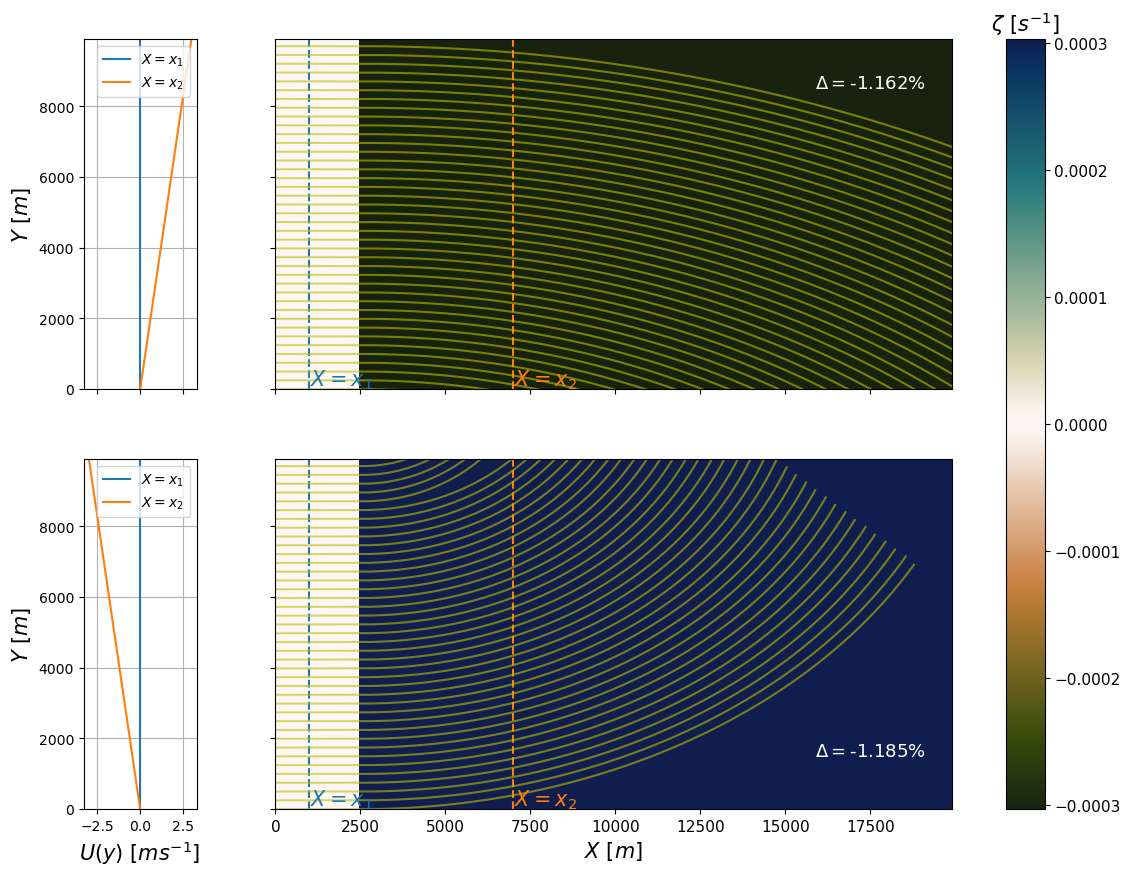

In [15]:
fs=15

idx_u0,idx_u1 =1000,7000

fig, ax = plt.subplots(nrows=2,ncols=2,sharex='col',sharey=True,figsize=(14,10),
                       gridspec_kw={'width_ratios': [1, 6]})

pc=ax[0,1].pcolormesh(wt.x,wt.y,vorticity[idt0],cmap=cmocean.cm.tarn,
                      vmin=vorticity.min(),vmax=np.abs(vorticity.min()),shading='auto')

for aax in [ax[0,1], ax[1,1]]:
    aax.axvline(idx_u0,0,ls='--',c='tab:blue')
    aax.text(idx_u0+20,100,r'$X=x_1$',c='tab:blue',fontsize=fs)
    aax.axvline(idx_u1,0,ls='--',c='tab:orange')
    aax.text(idx_u1+20,100,r'$X=x_2$',c='tab:orange',fontsize=fs)

pc1 = ax[1,1].pcolormesh(wt_pos_vort.x,wt_pos_vort.y,-vorticity[idt0],cmap=cmocean.cm.tarn,vmin=vorticity.min(),vmax=np.abs(vorticity.min()))


for i in range(0,wt.nb_wave_rays,5):
    ax[0,1].plot(wt.ray_x[i,:],wt.ray_y[i,:],'-y',alpha=0.6)
    ax[1,1].plot(wt_pos_vort.ray_x[i,:],wt_pos_vort.ray_y[i,:],'-y',alpha=0.6)
    
ax[0,1].set_xlim([X0,XN])
ax[0,1].set_ylim([Y0,YN])



ax[0,0].plot(wt.U.isel(time=idt0).sel(x=idx_u0),wt.y,c='tab:blue',label=r'$X=x_1$')
ax[0,0].plot(wt.U.isel(time=idt0).sel(x=idx_u1),wt.y,c='tab:orange',label=r'$X=x_2$')

ax[1,0].plot(wt_pos_vort.U.isel(time=idt0).sel(x=idx_u0),wt.y,c='tab:blue',label=r'$X=x_1$')
ax[1,0].plot(wt_pos_vort.U.isel(time=idt0).sel(x=idx_u1),wt.y,c='tab:orange',label=r'$X=x_2$')

for i,aax in enumerate([ax[0,0], ax[1,0]]):
    aax.legend(loc='upper right')
    aax.grid()    
    aax.set_ylabel(r'$Y~[m]$',fontsize=fs)
    if i == 1:
        aax.set_xlabel(r'$U(y)~[ms^{-1}]$',fontsize=fs)
    
ax[1,1].set_xlabel(r'$X~[m]$',fontsize=fs)
    

#fig.tight_layout()

cb0=fig.colorbar(pc,ax=ax)
cb0.ax.set_title(r'$\zeta~[s^{-1}]$',fontsize=fs)


ax[0,1].text(17500,8500,
            r'$\Delta=${}%'.format(np.round(rel_diff,3)),horizontalalignment='center',
            fontsize=fs-2,c='1')

ax[1,1].text(17500,1500,
            r'$\Delta=${}%'.format(np.round(rel_diff_pos,3)),horizontalalignment='center',
            fontsize=fs-2,c='1')


ax[0,1].tick_params(axis='both',labelsize=fs-4)
ax[1,1].tick_params(axis='both',labelsize=fs-4)
cb0.ax.tick_params(labelsize=fs-4)

#fig.savefig('wave_deflection.png',dpi=125)
#plt.close(fig)

In [16]:
tmp=wt.get_ray_curvature()


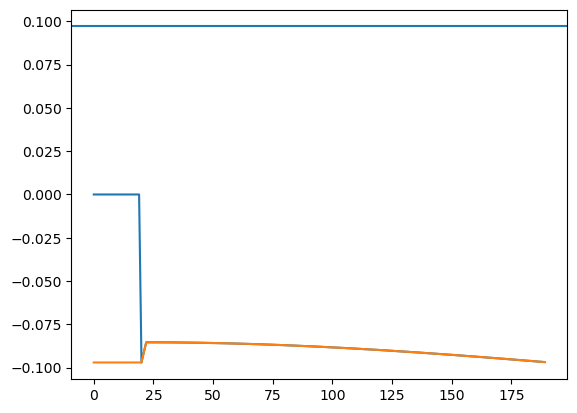

In [17]:
plt.plot(tmp[100]*l)
plt.plot((zeta_0*l)/wt.ray_cg[100])
#plt.plot(wt.ray_theta[100,idx])
plt.axhline(theta_analytical_pos)

(-0.09591646352606986, 0.09589353939619917)

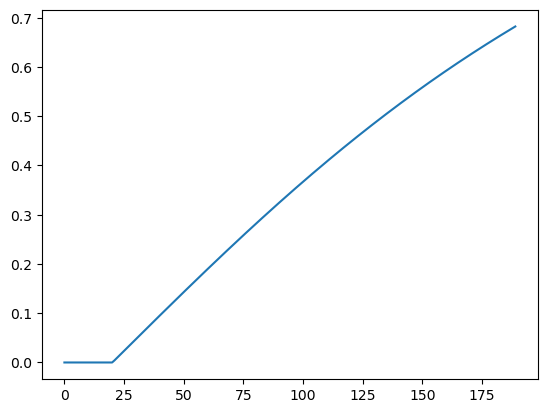

In [18]:
plt.plot(wt_pos_vort.ray_theta[100,:])
wt_pos_vort.ray_theta[100,idx]
-theta_wt,theta_wt_pos


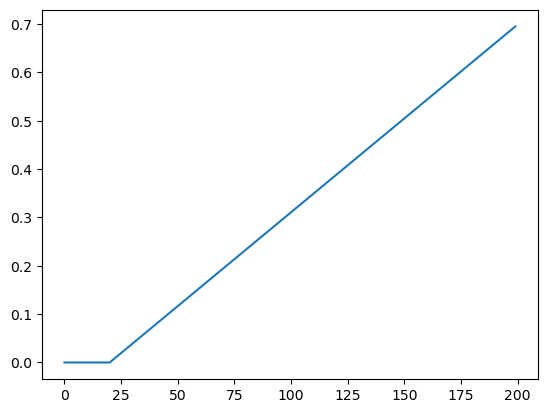

In [19]:
lengths = wt.x - wt.x[20]
lengths[lengths<0]=0
plt.plot(lengths*zeta_0_pos/cg)

## Summary
The wave ray delfection difference between negative and positive vorticity $\zeta$ is due to the advection of the current, which is also incorporated in the relative differences together with numerical noise. 

In [20]:
#try to back out the zeta by adding bathymetry!

In [21]:
# Solver bathyemetry only
wt_b = Wave_tracing(0*ncin.U_vorticity[idt0::,:,:], 0*ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                    d=ncin.bathymetry_1dy_slope.data
                     )
wt_b.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_b.solve()

/home/trygveh/miniconda3/envs/wave_tracing/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/trygveh/miniconda3/envs/wave_tracing/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [22]:
# Solver joint effects
wt_j = Wave_tracing(0.5*ncin.U_vorticity[idt0::,:,:], ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                    d=ncin.bathymetry_1dy_slope.data
                     )
wt_j.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_j.solve()

/home/trygveh/miniconda3/envs/wave_tracing/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/trygveh/miniconda3/envs/wave_tracing/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


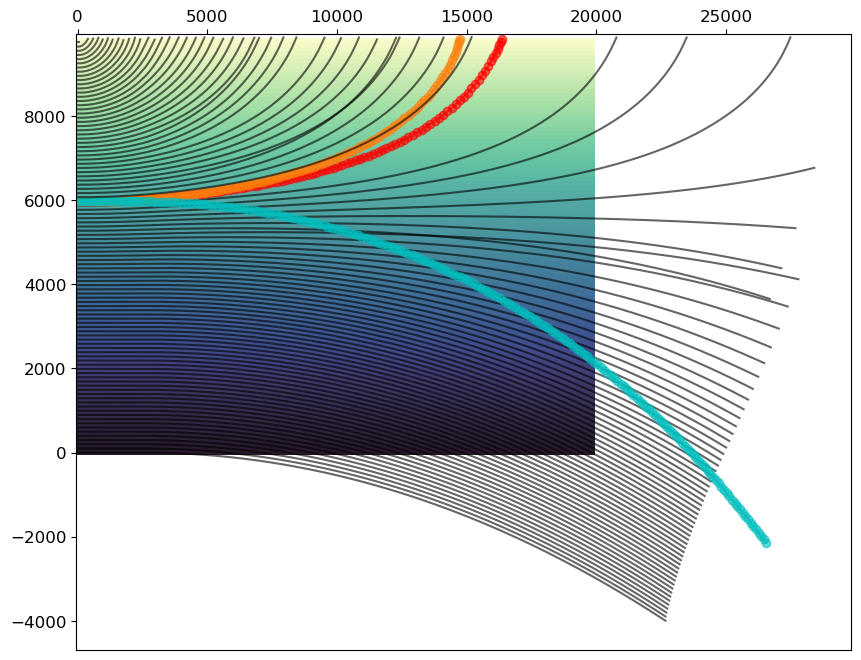

In [57]:
ray_id=120

fig,ax = plt.subplots(nrows=1,ncols=1,sharex=True,sharey=True,figsize=(10,8))
d_max=-150
fs=12
pc_d=ax.pcolormesh(wt_j.x,wt_j.y,-wt_j.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)



for i in range(0,wt_j.nb_wave_rays,2):
    if i == ray_id:
        ax.plot(wt_j.ray_x[i,:],wt_j.ray_y[i,:],'-or',alpha=0.6)
        ax.plot(wt_b.ray_x[i,:],wt_b.ray_y[i,:],'-o',c='tab:orange',alpha=0.6)
        ax.plot(wt.ray_x[i,:],wt.ray_y[i,:],'-oc',alpha=0.6)
    else:
        ax.plot(wt_j.ray_x[i,:],wt_j.ray_y[i,:],'-k',alpha=0.6)
ax.tick_params(labelsize=fs)
ax.xaxis.tick_top()

ax.plot(wt_j.ray_x[ray_id,110],wt_j.ray_y[ray_id,110],'s',c='m',alpha=0.6)

In [34]:
ray_curv_j = wt_j.get_ray_curvature()
ray_curv_b = wt_b.get_ray_curvature()
ray_curv_neg = wt.get_ray_curvature()

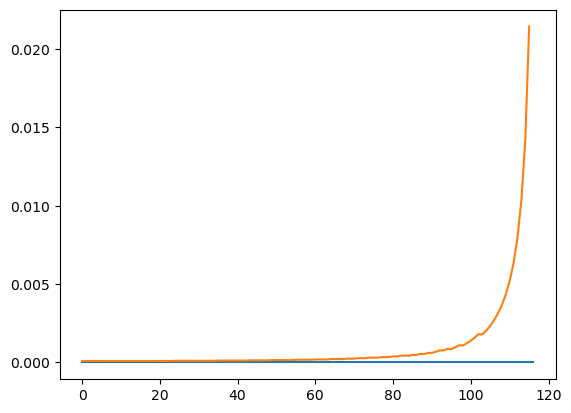

In [67]:
#plt.plot((wt.ray_ky[ray_id,:]))
plt.plot(np.diff(wt_b.ray_kx[ray_id,:]))
plt.plot(np.diff(wt_b.ray_ky[ray_id,:]))

## Theory

The wave ray equations may simplify to

$$\kappa = \frac{1}{c_g} (\zeta - \mathbf{n} \cdot \nabla  c)$$

$$c_g = \sqrt{c_{gx}^2 + c_{gy}^2} $$

$$\zeta = c_g \kappa + \mathbf{n} \cdot \nabla  c$$


In [25]:
# Analyical: see "kurve" artikkel on wiki
ds_j = wt_j.to_ds()
#ds_j = wt.to_ds()
myray = ds_j.isel(ray_id=ray_id)
xt, yt =ds_j.isel(ray_id=ray_id).ray_x,ds_j.isel(ray_id=ray_id).ray_y

In [26]:
time=ds_j.time
dt=time.diff(dim='time')[0]

In [27]:
#xprime = 
xprime=xt.differentiate(coord='time')
yprime=yt.differentiate(coord='time')

xprimeprime = xprime.differentiate(coord='time')
yprimeprime = yprime.differentiate(coord='time')



In [28]:
arclength=np.sqrt(xprime**2+yprime**2)

In [29]:
tx, ty = xprime/arclength, yprime/arclength

In [30]:
nx, ny = -yprime/arclength, xprime/arclength

In [31]:
kap = (xprime*yprimeprime - xprimeprime*yprime) / ((xprime**2+ yprime**2)**(1.5))

Text(0, 0.5, '$\\chi$')

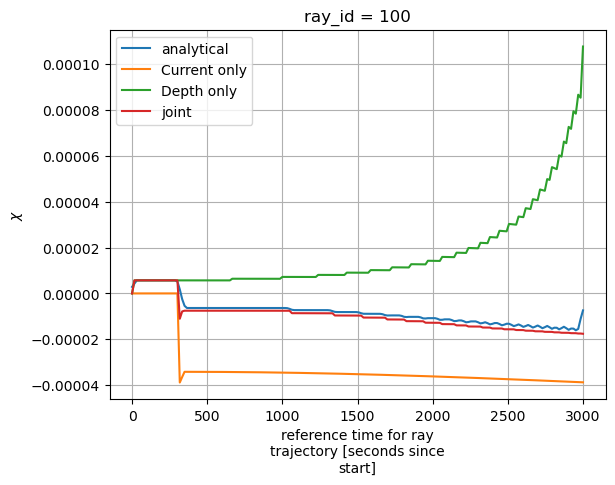

In [32]:
# comparing plot

fig,ax = plt.subplots()


kap.plot(label='analytical',ax=ax)
ax.plot(time,ray_curv_neg[ray_id,:],label='Current only')
ax.plot(time,ray_curv_b[ray_id,:],label='Depth only')
ax.plot(time,ray_curv_j[ray_id,:],label='joint')

ax.legend()
ax.grid()
ax.set_ylabel(r'$\chi$')

In [33]:
# comparing my normals
pi_half = 0.5*np.pi
tangent_vector = np.array([np.cos(ds_j.isel(ray_id=ray_id).ray_theta),
                           np.sin(ds_j.isel(ray_id=ray_id).ray_theta)])
normal_vector = np.array([np.cos(ds_j.isel(ray_id=ray_id).ray_theta+pi_half),
                          np.sin(ds_j.isel(ray_id=ray_id).ray_theta+pi_half)])

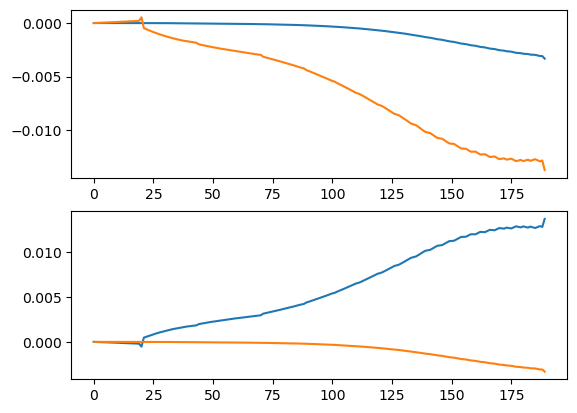

In [35]:
fig,ax = plt.subplots(nrows=2)
ax[0].plot(tangent_vector[0]-tx)
ax[0].plot(tangent_vector[1]-ty)
ax[1].plot(normal_vector[0]-nx)
ax[1].plot(normal_vector[1]-ny)

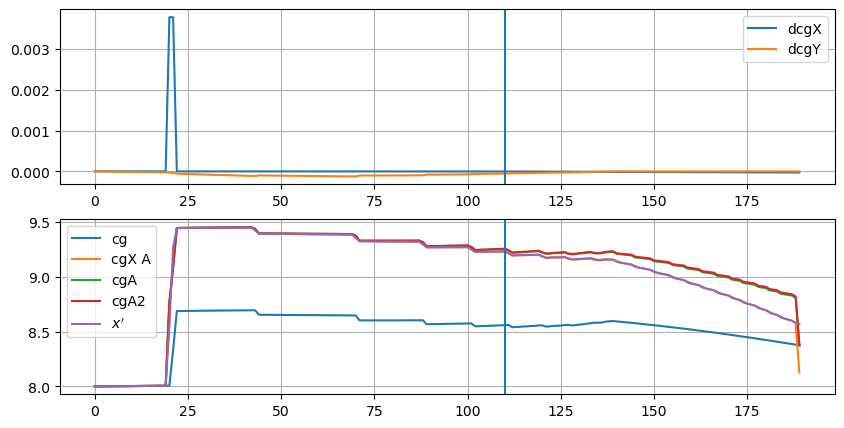

In [55]:
fig,ax = plt.subplots(nrows=2,figsize=(10,5))

cgX = myray.ray_cg*(myray.ray_kx/myray.ray_k)
cgY = myray.ray_cg*(myray.ray_ky/myray.ray_k)

cgXA = myray.ray_cg*(myray.ray_kx/myray.ray_k) + myray.ray_U
cgYA = myray.ray_cg*(myray.ray_ky/myray.ray_k) + myray.ray_V

cgA = np.sqrt(cgXA**2 + cgYA**2)        
cgA2 = myray.ray_cg + np.sqrt(myray.ray_U**2 + myray.ray_V**2)


ax[0].plot(wt_j.d_cgx[ray_id],label='dcgX')
ax[0].plot(wt_j.d_cgy[ray_id],label='dcgY')
ax[1].plot(myray.ray_cg,label='cg')

#ax[1].plot(cgX,label='cgX')
#ax[1].plot(cgY,label='cgY')

#ax[1].plot(np.sqrt(cgX**2+cgY**2),label='SIGG')
ax[1].plot(cgXA,label='cgX A')
#ax[1].plot(cgYA,label='cgY A')
ax[1].plot(cgA,label='cgA')
ax[1].plot(cgA2,label='cgA2')

ax[1].plot(xprime,label=r'$x^\prime$')
#ax[1].plot(yprime,label=r'$y^\prime$')


for aax in ax:
    aax.axvline(110)
    aax.grid()
    aax.legend()

In [37]:
myray.ray_cg

<xarray.DataArray 'ray_cg' (time: 190)>
array([8.00064702, 8.00064702, 8.00085493, 8.00131561, 8.00152395,
       8.00173221, 8.00194037, 8.00240072, 8.00260829, 8.00281528,
       8.00302187, 8.0034784 , 8.00368305, 8.00388671, 8.00433739,
       8.00453796, 8.00473709, 8.0049347 , 8.00537396, 8.00556674,
       8.00575728, 8.33150679, 8.68721561, 8.68751641, 8.68817167,
       8.68844087, 8.68905809, 8.68929971, 8.68988213, 8.69009987,
       8.69065009, 8.69084755, 8.6913677 , 8.6915477 , 8.69203984,
       8.69220478, 8.69267051, 8.69282251, 8.69326303, 8.69340382,
       8.69381975, 8.69395083, 8.69434274, 8.69446506, 8.65347275,
       8.65321169, 8.65274237, 8.65249205, 8.65204952, 8.65181103,
       8.65139667, 8.65117079, 8.65078598, 8.65057339, 8.65021859,
       8.65001987, 8.64969595, 8.64951105, 8.64921848, 8.64904783,
       8.64878677, 8.64863006, 8.64840045, 8.64825773, 8.64805952,
       8.64793028, 8.64776323, 8.64764689, 8.64751048, 8.64740668,
       8.64730034, 8.60229493, 8.60218685, 8.60206843, 8.60203737,
       8.60194826, 8.60186746, 8.60193658, 8.60188391, 8.60202755,
       8.6020019 , 8.60221884, 8.60221902, 8.60250763, 8.60253214,
       8.60289079, 8.60293805, 8.60336452, 8.603433  , 8.56732927,
       8.56753394, 8.56843674, 8.56867516, 8.56967875, 8.56994889,
       8.57105091, 8.57135061, 8.5716571 , 8.57288332, 8.57321596,
       8.57453368, 8.57488986, 8.5480949 , 8.54867399, 8.55067809,
       8.55129247, 8.55341899, 8.55406568, 8.55631109, 8.5569866 ,
       8.55934692, 8.56004744, 8.53925378, 8.54236667, 8.54336504,
       8.54663122, 8.54766622, 8.55108115, 8.5521478 , 8.555706  ,
       8.55679849, 8.54563483, 8.54709128, 8.5517218 , 8.55321801,
       8.55471863, 8.55958421, 8.56111339, 8.55659847, 8.5585656 ,
       8.56474144, 8.5667493 , 8.57314963, 8.57518503, 8.58179402,
       8.58032312, 8.58288143, 8.5909567 , 8.5935395 , 8.59611368,
       8.59298558, 8.58983297, 8.5864894 , 8.58312263, 8.57973282,
       8.5763201 , 8.57288464, 8.56926557, 8.56562514, 8.56196349,
       8.55828079, 8.55457719, 8.55069766, 8.54679866, 8.54288034,
       8.53894287, 8.5349864 , 8.53086193, 8.52671993, 8.52256055,
       8.51838394, 8.51404653, 8.50969338, 8.50532464, 8.50094046,
       8.49640285, 8.49185129, 8.48728594, 8.48270692, 8.4779819 ,
       8.47324471, 8.46849551, 8.46373442, 8.45883478, 8.45392474,
       8.44900442, 8.44395213, 8.43889102, 8.43382123, 8.42874288,
       8.42353999, 8.41832998, 8.41311294, 8.4077779 , 8.40243723,
       8.39709105, 8.39163331, 8.38617142, 8.38070546, 8.37523554])
Coordinates:
    ray_id   int64 100
  * time     (time) float64 0.0 15.87 31.75 47.62 ... 2.968e+03 2.984e+03 3e+03
Attributes:
    long_name:      wave intrinsic group speed
    standard_name:  
    units:          ms-1